In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import utils

random_wav = "bass_electronic_018-022-100.wav"

audio = utils.load_audio(random_wav)
sample_length = audio.shape[0]
print(sample_length)
audio = np.concatenate((audio, audio))
 

64000


[  0.00000000e+00   6.10351562e-05   2.13623047e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


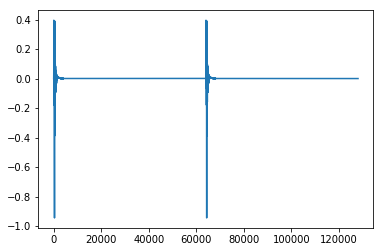

In [4]:
print(audio)

%matplotlib inline
plt.plot(audio)
plt.show()

In [5]:
import tensorflow as tf
learning_rate = 0.00001
num_lstm = 512
with tf.Graph().as_default():
    #session_config = tf.Config
    with tf.Session() as sess:
        lstm = tf.contrib.rnn.BasicLSTMCell(num_lstm)
        #initial_state = tf.zeros([batch_size, lstm.state_size])
        
#encode with 8 bit mu-law
x = audio
x_quantized = utils.mu_law(x)
x_scaled = x_quantized / 128
num_z = 16
print(x_scaled)

Tensor("truediv_1:0", shape=(128000,), dtype=float32)


In [6]:
num_layers = 1
num_steps = 1
input_size = 1
lstm_size = 128
keep_prob = 1
stock_count = 1
embed_size = 1

In [144]:
tf.reset_default_graph()

#official tutorial: words_in_dataset = tf.placeholder(tf.float32, [time_steps, batch_size, num_features])
learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")
# symbols are mapped to integers.
symbols = tf.placeholder(tf.int32, [None, 1], name='symbols')
inputs = tf.placeholder(tf.float32, [None, num_steps, input_size], name="inputs")

#inputs = tf.reshape(inputs, tf.TensorShape([64000,1,1]))
targets = tf.placeholder(tf.float32, [None, input_size], name="targets")

def _create_one_cell():
    lstm_cell = tf.contrib.rnn.LSTMCell(lstm_size, state_is_tuple=True)
    '''
    if keep_prob < 1.0:
        lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)    '''
    return lstm_cell

cell = tf.contrib.rnn.MultiRNNCell([_create_one_cell() for _ in range(num_layers)],state_is_tuple=True
) if num_layers > 1 else _create_one_cell()


#embedding layer
embed_matrix = tf.Variable(
    tf.random_uniform([stock_count, embed_size], -1.0, 1.0),
    name="embed_matrix"
)
sym_embeds = tf.nn.embedding_lookup(embed_matrix, symbols)
            
# stock_label_embeds.shape = (batch_size, embedding_size)
stacked_symbols = tf.tile(symbols, [1, num_steps], name='stacked_stock_labels')
stacked_embeds = tf.nn.embedding_lookup(embed_matrix, stacked_symbols)

# After concat, inputs.shape = (batch_size, num_steps, lstm_size + embed_size)
inputs_with_embed = tf.concat([inputs, stacked_embeds], axis=2, name="inputs_with_embed")

val, state_ = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32, scope="dynamic_rnn")

# Before transpose, val.get_shape() = (batch_size, num_steps, lstm_size)
# After transpose, val.get_shape() = (num_steps, batch_size, lstm_size)
val = tf.transpose(val, [1, 0, 2])
last = tf.gather(val, int(val.get_shape()[0]) - 1, name="lstm_state")
ws = tf.Variable(tf.truncated_normal([lstm_size, input_size]), name="w")
bias = tf.Variable(tf.constant(0.1, shape=[input_size]), name="b")
pred = tf.matmul(last, ws) + bias

loss = tf.reduce_mean(tf.square(pred - targets), name="loss_mse")
optim = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, name="rmsprop_optim")

/home/keplerc/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [145]:
audio = utils.load_audio(random_wav)
audio = list(map(lambda x: x, audio))
np.array(audio)

array([  0.00000000e+00,   6.10351562e-05,   2.13623047e-04, ...,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00], dtype=float32)

In [146]:
import numpy as np
import pandas as pd
import random

#normalized does not work
class dt():
    def __init__(self, raw_audio, input_size = input_size, num_steps = num_steps, test_ratio = 0.1, normalized = False):
        self.raw_seq = np.array(raw_audio)
        self.input_size = input_size
        self.num_steps = num_steps 
        self.test_ratio = test_ratio
        self.normalized = normalized
        self.train_X, self.train_y, self.test_X, self.test_y = self._prepare_data(self.raw_seq)

    def _prepare_data(self, seq):
        # split into items of input_size
        seq = [np.array(seq[i * self.input_size: (i + 1) * self.input_size])
               for i in range(len(seq) // self.input_size)]
        
        if self.normalized:
            seq = [seq[0] / seq[0][0] - 1.0] + [
                curr / seq[i][-1] - 1.0 for i, curr in enumerate(seq[1:])]

        # split into groups of num_steps
        X = np.array([seq[i: i + self.num_steps] for i in range(len(seq) - self.num_steps)])
        y = np.array([seq[i + self.num_steps] for i in range(len(seq) - self.num_steps)])

        train_size = int(len(X) * (1.0 - self.test_ratio))
        train_X, test_X = X[:train_size], X[train_size:]
        train_y, test_y = y[:train_size], y[train_size:]
        return train_X, train_y, test_X, test_y

    def generate_one_epoch(self, batch_size):
        num_batches = int(len(self.train_X)) // batch_size
        if batch_size * num_batches < len(self.train_X):
            num_batches += 1

        batch_indices = list(range(num_batches))
        random.shuffle(batch_indices)
        for j in batch_indices:
            batch_X = self.train_X[j * batch_size: (j + 1) * batch_size]
            batch_y = self.train_y[j * batch_size: (j + 1) * batch_size]
            assert set(map(len, batch_X)) == {self.num_steps}
            yield batch_X, batch_y

In [147]:
batch_size = 100
batch_labels = np.ones([batch_size,1])
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    merged_test_X = np.array(audio)
    merged_test_y = np.array(audio)

    global_step = 0
    epoch_step = 0
    d = dt(audio, test_ratio=0)
    for batch_x, batch_y in d.generate_one_epoch(batch_size):
        global_step += 1
        epoch_step += 1
        train_data_feed = {
            learning_rate : 0.00001,
            inputs: batch_x,
            targets: batch_y,
            symbols: batch_labels,
        }
        train_loss, _ = sess.run([loss, optim], train_data_feed)
        if(global_step % 10 == 0):
            print(train_loss)
    
    test_data_feed = {
            learning_rate : 0.00001,
            inputs: d.train_X,
            targets: d.train_y,
            symbols: batch_labels,
    }
    test_loss, test_pred = sess.run([loss, pred], test_data_feed)

0.00996972
0.00991638
0.00982873
0.00964791
0.00949599
0.00922794
0.00920783
0.00854127
0.00817318
0.00779475
0.00742483
0.00708643
0.00671388
0.00635843
0.00601442
0.00567504
0.00536003
0.00504839
0.0047484
0.0044527
0.00416741
0.00389149
0.00362551
0.00336865
0.0031216
0.00288468
0.00265679
0.00243596
0.00223002
0.00203219
0.00184449
0.0016632
0.00149494
0.00133301
0.00118116
0.00103956
0.000906802
0.000784637
0.0481672
0.000656264
0.00056345
0.000472101
0.000380948
0.000353106
0.000313596
0.000265665
0.000214321
0.000162952
0.000118137
8.09437e-05
5.14075e-05
2.93961e-05
1.43797e-05
5.51477e-06
1.63645e-06
1.85324e-07
2.0358e-07
7.36123e-10
3.75426e-10
9.27099e-11
2.68015e-10
2.48144e-09
4.13544e-07
1.80223e-07


In [148]:
print(test_pred)

[[-0.00038607]
 [-0.00038524]
 [-0.00038315]
 ..., 
 [-0.00038607]
 [-0.00038607]
 [-0.00038607]]


(63999,)
(63999,)
(63999,)


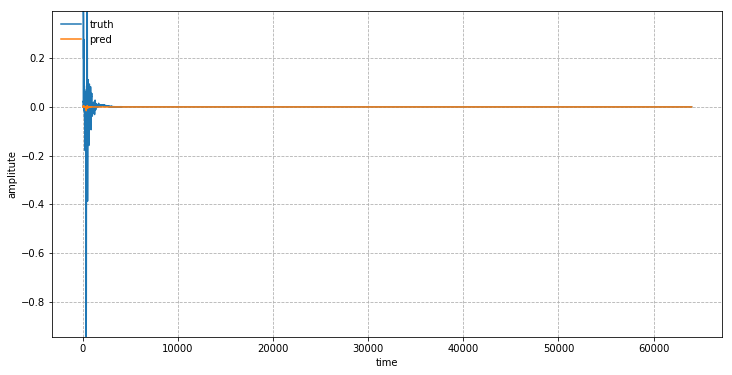

In [149]:
def _flatten(seq):
    return [x for y in seq for x in y]

truths = np.array(audio[:-1])
preds = np.array(_flatten(test_pred))
print(truths.shape)
print(preds.shape)
days = np.array(range(len(truths))[-127999:])
print(days.shape)

plt.figure(figsize=(12, 6))
plt.plot(days, truths, label='truth')
plt.plot(days, preds, label='pred')
plt.legend(loc='upper left', frameon=False)
plt.xlabel("time")
plt.ylabel("amplitute")
plt.ylim((min(truths), max(truths)))
plt.grid(ls='--')
plt.show()

In [10]:
import numpy as np
import tensorflow as tf

tf.reset_default_graph()
sess = tf.InteractiveSession()

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2
#time, batch, depth
encoder_inputs = tf.placeholder(shape=(None, num_steps, input_size), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, input_size), dtype=tf.int32, name='decoder_targets')
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32, time_major=True,
)

decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)
print(encoder_final_state)
print(decoder_inputs_embedded)
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,
    initial_state=encoder_final_state,
    dtype=tf.float32, time_major=True, scope="plain_decoder",
)
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)

decoder_prediction = tf.argmax(decoder_logits, 2)

stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

sess.run(tf.global_variables_initializer())


ValueError: Shape (1, 1, 20) must have rank 2

In [11]:
tf.reset_default_graph()
batch_size = 100
#official tutorial: words_in_dataset = tf.placeholder(tf.float32, [time_steps, batch_size, num_features])
inputs = tf.placeholder(tf.float32, [None, num_steps, input_size], name="inputs")
inputs_t = tf.transpose(inputs, [1, 0, 2])
targets = tf.placeholder(tf.float32, [None, input_size], name="targets")

cell = tf.contrib.rnn.LSTMCell(lstm_size, state_is_tuple=True)
val, encoder_final_state = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32, scope="dynamic_rnn")

# Before transpose, val.get_shape() = (batch_size, num_steps, lstm_size)
# After transpose, val.get_shape() = (num_steps, batch_size, lstm_size)
print(encoder_final_state)
decoder_outputs = tf.ones((num_steps, batch_size, lstm_size))
'''
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    cell, decoder_inputs,
    initial_state=encoder_final_state,
    dtype=tf.float32, time_major=True, scope="plain_decoder",
)
'''
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)

decoder_prediction = tf.argmax(decoder_logits, 2)

stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

#sess.run(tf.global_variables_initializer())


LSTMStateTuple(c=<tf.Tensor 'dynamic_rnn/while/Exit_2:0' shape=(?, 128) dtype=float32>, h=<tf.Tensor 'dynamic_rnn/while/Exit_3:0' shape=(?, 128) dtype=float32>)


ValueError: Tensor("Reshape:0", shape=(?, ?), dtype=float32) must be from the same graph as Tensor("Reshape:0", shape=(100, 10), dtype=float32).